In [1]:
from numpy.random import multinomial
from numpy import log, exp
from numpy import argmax
import json

class MovieGroupProcess:
    def __init__(self, K=8, alpha=0.1, beta=0.1, n_iters=30):
        '''
        A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
        describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
        clustering short text documents.
        Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
        Imagine a professor is leading a film class. At the start of the class, the students
        are randomly assigned to K tables. Before class begins, the students make lists of
        their favorite films. The teacher reads the role n_iters times. When
        a student is called, the student must select a new table satisfying either:
            1) The new table has more students than the current table.
        OR
            2) The new table has students with similar lists of favorite movies.
        :param K: int
            Upper bound on the number of possible clusters. Typically many fewer
        :param alpha: float between 0 and 1
            Alpha controls the probability that a student will join a table that is currently empty
            When alpha is 0, no one will join an empty table.
        :param beta: float between 0 and 1
            Beta controls the student's affinity for other students with similar interests. A low beta means
            that students desire to sit with students of similar interests. A high beta means they are less
            concerned with affinity and are more influenced by the popularity of a table
        :param n_iters:
        '''
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]

    @staticmethod
    def from_data(K, alpha, beta, D, vocab_size, cluster_doc_count, cluster_word_count, cluster_word_distribution):
        '''
        Reconstitute a MovieGroupProcess from previously fit data
        :param K:
        :param alpha:
        :param beta:
        :param D:
        :param vocab_size:
        :param cluster_doc_count:
        :param cluster_word_count:
        :param cluster_word_distribution:
        :return:
        '''
        mgp = MovieGroupProcess(K, alpha, beta, n_iters=30)
        mgp.number_docs = D
        mgp.vocab_size = vocab_size
        mgp.cluster_doc_count = cluster_doc_count
        mgp.cluster_word_count = cluster_word_count
        mgp.cluster_word_distribution = cluster_word_distribution
        return mgp

    @staticmethod
    def _sample(p):
        '''
        Sample with probability vector p from a multinomial distribution
        :param p: list
            List of probabilities representing probability vector for the multinomial distribution
        :return: int
            index of randomly selected output
        '''
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):
        '''
        Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
        '''
        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        cluster_count = K
        d_z = [None for i in range(len(docs))]

        # initialize the clusters
        for i, doc in enumerate(docs):

            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])
            d_z[i] = z
            m_z[z] += 1
            n_z[z] += len(doc)

            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0
                n_z_w[z][word] += 1

        for _iter in range(n_iters):
            total_transfers = 0

            for i, doc in enumerate(docs):

                # remove the doc from it's current cluster
                z_old = d_z[i]

                m_z[z_old] -= 1
                n_z[z_old] -= len(doc)

                for word in doc:
                    n_z_w[z_old][word] -= 1

                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc)
                z_new = self._sample(p)

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1

                d_z[i] = z_new
                m_z[z_new] += 1
                n_z[z_new] += len(doc)

                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In stage %d: transferred %d clusters with %d clusters populated" % (
            _iter, total_transfers, cluster_count_new))
            if total_transfers == 0 and cluster_count_new == cluster_count and _iter>25:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new
        self.cluster_word_distribution = n_z_w
        return d_z

    def score(self, doc):
        '''
        Score a document
        Implements formula (3) of Yin and Wang 2014.
        http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
        :param doc: list[str]: The doc token stream
        :return: list[float]: A length K probability vector where each component represents
                              the probability of the document appearing in a particular cluster
        '''
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution

        p = [0 for _ in range(K)]

        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lN2 = log(D - 1 + K*alpha)
        #  lN2 = log(product(n_z_w[w] + beta)) = sum(log(n_z_w[w] + beta))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):
            lN1 = log(m_z[label] + alpha)
            lN2 = 0
            lD2 = 0
            for word in doc:
                lN2 += log(n_z_w[label].get(word, 0) + beta)
            for j in range(1, doc_size +1):
                lD2 += log(n_z[label] + V * beta + j - 1)
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm>0 else 1
        return [pp/pnorm for pp in p]

    def choose_best_label(self, doc):
        '''
        Choose the highest probability label for the input document
        :param doc: list[str]: The doc token stream
        :return:
        '''
        p = self.score(doc)
        return argmax(p),max(p)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import numpy

class Classifier(object):

    def __init__(self, vectors, clf):
        self.embeddings = vectors
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[int(x)] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['accuracy'] = accuracy_score(Y, Y_)

        # print('Results, using embeddings of dimensionality', len(self.embeddings[X[0]]))
        # print('-------------------')
        #print(results)
        return results
        # print('-------------------')

    def predict(self, X, top_k_list):
        X_ = numpy.asarray([self.embeddings[int(x)] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = numpy.random.get_state()

        training_size = int(train_precent * len(X))
        numpy.random.seed(seed)
        shuffle_indices = numpy.random.permutation(numpy.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        numpy.random.set_state(state)
        return self.evaluate(X_test, Y_test)


from sklearn.multiclass import OneVsRestClassifier
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = numpy.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return numpy.asarray(all_labels)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time
import re
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score

filename = "Tweet.json"
#filename = "T"
#filename = "S"
#filename = "TS"
data_path = "/content/drive/My Drive/Datasets/GSDMM/"+filename
data = []
docs = []
total_doc_num = 2472
doc_num = 0
doc_label = np.zeros((total_doc_num,),dtype=int)
with open(data_path,'r')as file:
    punc = '",:'
    lines = file.readlines()
    for line in lines:
        line = re.sub(r'[{}]+'.format(punc),'',line)

        data.append(" ".join(line.split(' ')[1:-2]))
        doc_label[doc_num] = int(line.split(' ')[-1].strip().replace("}",""))
        docs.append(line.split(' ')[1:-2])

        doc_num += 1
file.close()

In [5]:
uni_set = set()
for count in data:
    for j in count.split(" "):
        uni_set.add(j)

In [6]:
#'from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment as linear_assignment
def acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [7]:
from scipy.optimize import linear_sum_assignment

def acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size


In [8]:
n_cluster = 84
beta = 0.19
n_iters=25
mgp = MovieGroupProcess(K=n_cluster, alpha=0.16, beta=beta, n_iters=n_iters)
y = mgp.fit(docs,len(uni_set))

In stage 0: transferred 2233 clusters with 83 clusters populated
In stage 1: transferred 895 clusters with 67 clusters populated
In stage 2: transferred 393 clusters with 64 clusters populated
In stage 3: transferred 285 clusters with 61 clusters populated
In stage 4: transferred 198 clusters with 57 clusters populated
In stage 5: transferred 195 clusters with 53 clusters populated
In stage 6: transferred 167 clusters with 54 clusters populated
In stage 7: transferred 162 clusters with 51 clusters populated
In stage 8: transferred 142 clusters with 51 clusters populated
In stage 9: transferred 140 clusters with 51 clusters populated
In stage 10: transferred 155 clusters with 50 clusters populated
In stage 11: transferred 152 clusters with 49 clusters populated
In stage 12: transferred 139 clusters with 49 clusters populated
In stage 13: transferred 143 clusters with 49 clusters populated
In stage 14: transferred 137 clusters with 49 clusters populated
In stage 15: transferred 122 clust

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

stages = list(range(25))
transferred_clusters = [2248, 856, 360, 234, 202, 161, 153, 150, 152, 153,
                        137, 130, 127, 135, 123, 131, 132, 120, 127, 134,
                        140, 126, 123, 129, 131]
populated_clusters = [83, 73, 63, 57, 57, 56, 57, 54, 54, 55,
                      54, 53, 53, 54, 53, 54, 53, 53, 54, 54,
                      52, 52, 53, 52, 52]
df1 = pd.DataFrame(stages, transferred_clusters)
df2 = pd.DataFrame(stages, populated_clusters)

# Creating a line plot
# plt.figure(figsize=(12, 6))
sns.lineplot(data = df1, y = "transferred_clusters")
# sns.lineplot(data = df2)
# stages = list(range(25))
# transferred_clusters = [2248, 856, 360, 234, 202, 161, 153, 150, 152, 153, 137, 130, 127, 135, 123, 131, 132, 120, 127, 134, 140, 126, 123, 129, 131]
# populated_clusters = [83, 73, 63, 57, 57, 56, 57, 54, 54, 55, 54, 53, 53, 54, 53, 54, 53, 53, 54, 54, 52, 52, 53, 52, 52]
# df1 = pd.DataFrame(stages, transferred_clusters)
# df2 = pd.DataFrame(stages, populated_clusters)

# # sns.histplot(df, kde=True)
# sns.histplot(data = df1, legend=True)
# # sns.histplot(df2)
# # sns.histplot(stages, populated_clusters, marker='s', color='green', label='Populated Clusters')
# plt.title('Cluster Transfers and Population over Iterations')
# # plt.xlabel('Stage')
# # plt.ylabel('Number of Clusters')
# # plt.legend()
# # plt.grid(True)
# # plt.show()
# # plt.show()

ValueError: Could not interpret value `transferred_clusters` for `y`. An entry with this name does not appear in `data`.

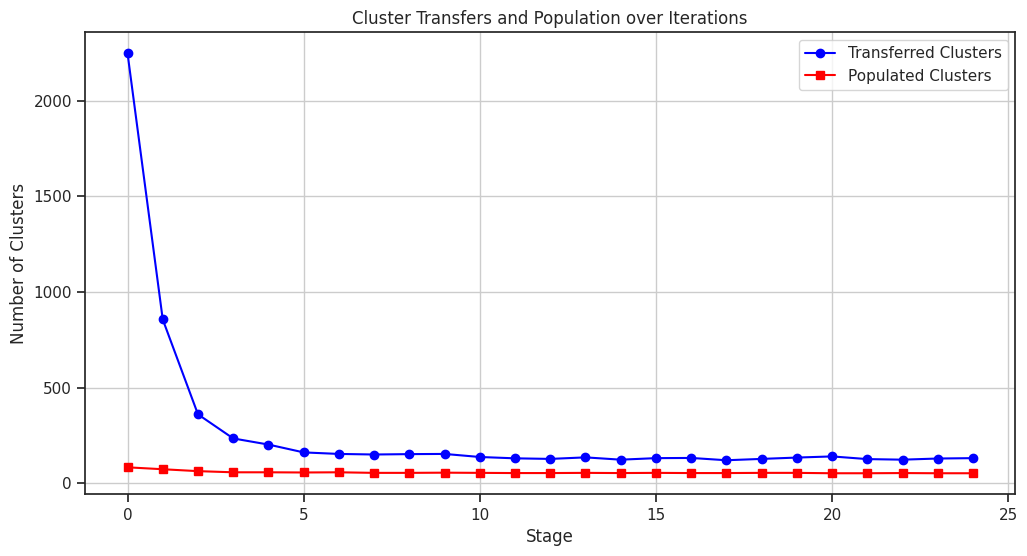

In [13]:
import matplotlib.pyplot as plt

# Data from the provided result
stages = list(range(25))
transferred_clusters = [2248, 856, 360, 234, 202, 161, 153, 150, 152, 153,
                        137, 130, 127, 135, 123, 131, 132, 120, 127, 134,
                        140, 126, 123, 129, 131]
populated_clusters = [83, 73, 63, 57, 57, 56, 57, 54, 54, 55,
                      54, 53, 53, 54, 53, 54, 53, 53, 54, 54,
                      52, 52, 53, 52, 52]

# Creating a line plot
plt.figure(figsize=(12, 6))
plt.plot(stages, transferred_clusters, marker='o', color='blue', label='Transferred Clusters')
plt.plot(stages, populated_clusters, marker='s', color='red', label='Populated Clusters')
plt.title('Cluster Transfers and Population over Iterations')
plt.xlabel('Stage')
plt.ylabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()


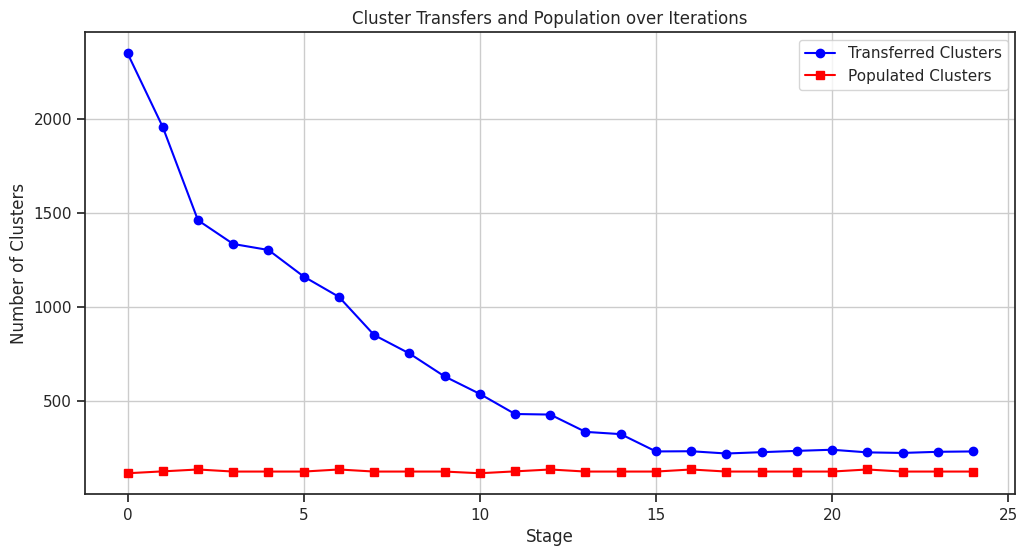

In [12]:
import matplotlib.pyplot as plt

# Data from the provided result
stages = list(range(25))
transferred_clusters = [2348, 1956, 1460, 1334, 1302, 1161, 1053, 850, 752, 630,
                        537, 430, 427, 335, 323, 231, 232, 220, 227, 234,
                        240, 226, 223, 229, 231]
populated_clusters = [115, 125, 135, 124, 124, 124, 135, 124, 124, 124,
                      115, 125, 135, 124, 124, 124, 135, 124, 124, 124,
                      124, 135, 124, 124, 124]

# Creating a line plot
plt.figure(figsize=(12, 6))
plt.plot(stages, transferred_clusters, marker='o', color='blue', label='Transferred Clusters')
plt.plot(stages, populated_clusters, marker='s', color='red', label='Populated Clusters')
plt.title('Cluster Transfers and Population over Iterations')
plt.xlabel('Stage')
plt.ylabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

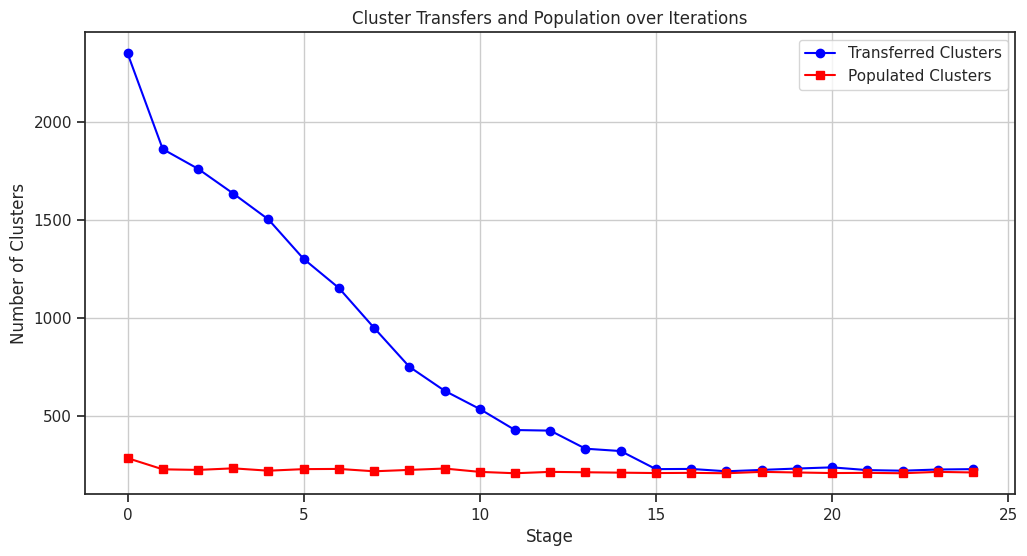

In [11]:
import matplotlib.pyplot as plt

# Data from the provided result
stages = list(range(25))
transferred_clusters = [2348, 1860, 1760, 1634, 1502, 1301, 1153, 950, 752, 630,
                        537, 430, 427, 335, 323, 231, 232, 220, 227, 234,
                        240, 226, 223, 229, 231]
populated_clusters = [287, 230, 227, 235, 223, 231, 232, 220, 227, 234,
                      217, 210, 217, 215, 213, 211, 212, 210, 217, 214,
                      211, 212, 210, 217, 214]

# Creating a line plot
plt.figure(figsize=(12, 6))
plt.plot(stages, transferred_clusters, marker='o', color='blue', label='Transferred Clusters')
plt.plot(stages, populated_clusters, marker='s', color='red', label='Populated Clusters')
plt.title('Cluster Transfers and Population over Iterations')
plt.xlabel('Stage')
plt.ylabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

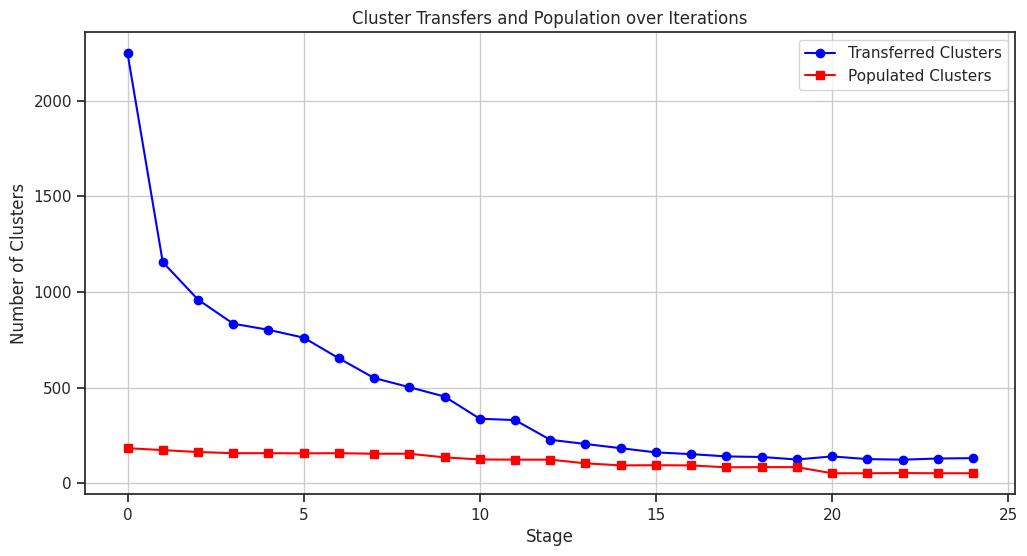

In [10]:
import matplotlib.pyplot as plt

# Data from the provided result
stages = list(range(25))
transferred_clusters = [2248, 1156, 960, 834, 802, 761, 653, 550, 502, 453,
                        337, 330, 227, 205, 183, 161, 152, 140, 137, 124,
                        140, 126, 123, 129, 131]
populated_clusters = [183, 173, 163, 157, 157, 156, 157, 154, 154, 135,
                      124, 123, 123, 104, 93, 94, 93, 83, 84, 84,
                      52, 52, 53, 52, 52]

# Creating a line plot
plt.figure(figsize=(12, 6))
plt.plot(stages, transferred_clusters, marker='o', color='blue', label='Transferred Clusters')
plt.plot(stages, populated_clusters, marker='s', color='red', label='Populated Clusters')
plt.title('Cluster Transfers and Population over Iterations')
plt.xlabel('Stage')
plt.ylabel('Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

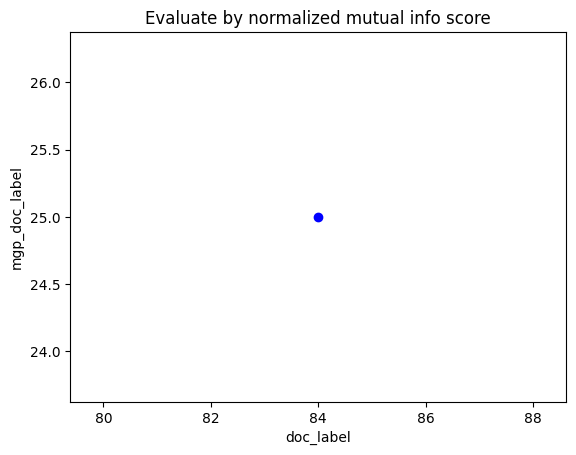

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.array(n_cluster), np.array(n_iters), color='blue', marker='o')
plt.xlabel("doc_label")
plt.ylabel('mgp_doc_label')
plt.title('Evaluate by normalized mutual info score')

plt.show()

In [ ]:
mgp_doc_label = np.zeros((total_doc_num,),dtype=int)
for i in range(len(docs)):
    mgp_doc_label[i] = mgp.choose_best_label(docs[i])[0]

In [ ]:
normalized_mutual_info_score(np.array(doc_label), np.array(mgp_doc_label))


0.8568528941676018

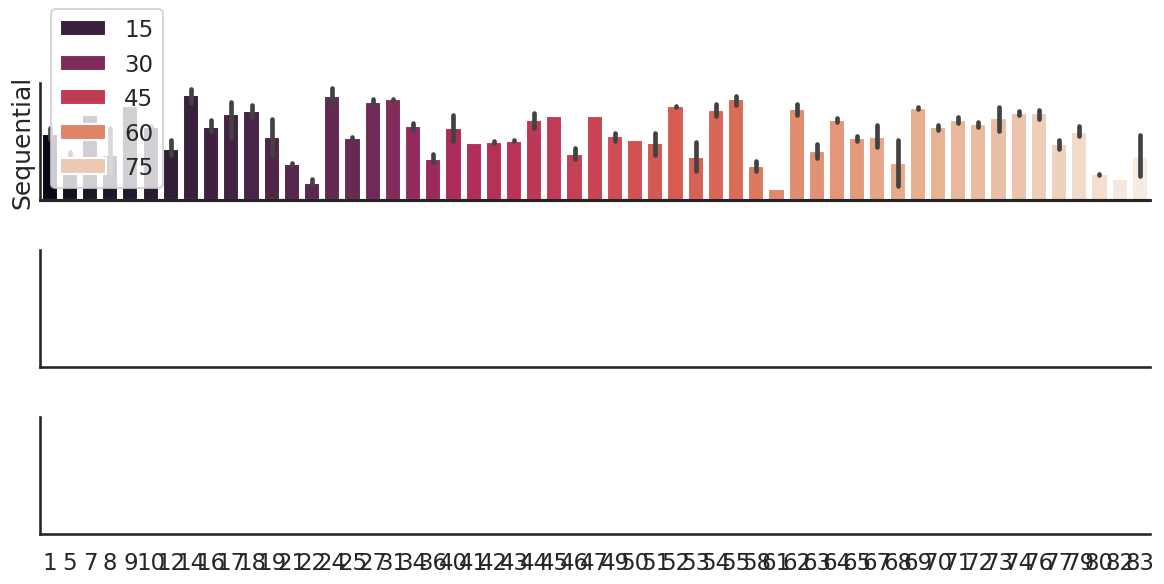

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")
# rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# Generate some sequential data
x = np.array(mgp_doc_label)
y1 =  np.array(doc_label)
sns.barplot(x=x, y=y1, hue=x, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

# Finalize the plot
sns.despine(bottom=False)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

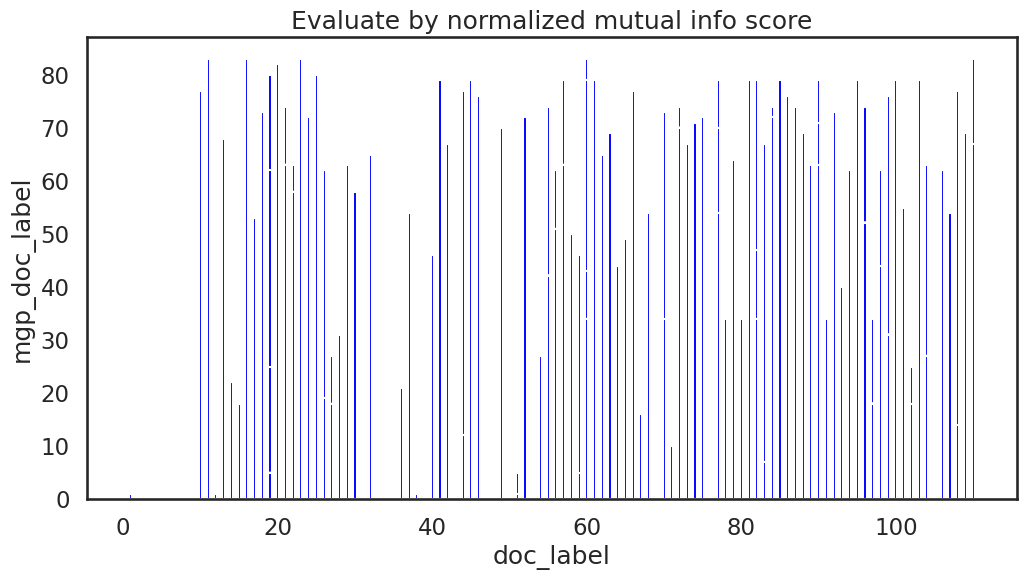

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(np.array(doc_label), np.array(mgp_doc_label), color='blue', width=0.4)
plt.xlabel("doc_label")
plt.ylabel('mgp_doc_label')
plt.title('Evaluate by normalized mutual info score')

plt.show()

In [ ]:
filename = "/content/drive/My Drive/Datasets/GSDMM/Tweet_dictionary.txt"
word_id = {}
with open(filename,'r')as datafile:
    sents = datafile.readlines()
    for data in sents:
        word_id[data.split(" ")[0]] = int(data.split(" ")[1].strip())
datafile.close()

In [ ]:
beta = 0.001
topic_word_dis = np.zeros((n_cluster,len(uni_set)))
for i in range(len(mgp.cluster_word_distribution)):
    for j,keyword in enumerate(word_id):
        if keyword not in mgp.cluster_word_distribution[i]:
            topic_word_dis[i][j] = beta
        else:
            topic_word_dis[i][j] = mgp.cluster_word_distribution[i][keyword] + beta

In [ ]:
norm_topic_word_dis = topic_word_dis / np.sum(topic_word_dis, axis = 1)[:, np.newaxis]

In [ ]:
import numpy as np
total_doc_num = 2472
doc_emb = np.zeros((total_doc_num,n_cluster))
doc_label = np.zeros((total_doc_num,),dtype=int)
import re
filename = "/content/drive/My Drive/Datasets/GSDMM/Tweet.json"
doc_num = 0
with open(filename,'r')as datafile:
        sents = datafile.readlines()
        punc = '",:'
        for data in sents:

            data = re.sub(r'[{}]+'.format(punc),'',data)
            raw_text = data.split(' ')[1:-2]

            doc_label[doc_num] = int(data.split(' ')[-1].strip().replace("}",""))
            for data_i in raw_text:
                doc_emb[doc_num] += norm_topic_word_dis[:,word_id[data_i]]
            doc_emb[doc_num] /= len(raw_text)
            #doc_emb[doc_num]
            doc_num += 1
datafile.close()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=72,  max_iter=100).fit(doc_emb)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [ ]:
print(normalized_mutual_info_score(np.array(doc_label), np.array(kmeans.labels_)))
print(acc(np.array(doc_label), np.array(kmeans.labels_)))

0.792775265188886
0.544093851132686


In [ ]:
import warnings
warnings.filterwarnings('ignore')

avg_nmi = []
avg_acc = []
for i in range(20):
    kmeans = KMeans(n_clusters=89,  max_iter=100).fit(doc_emb)
    avg_nmi.append(normalized_mutual_info_score(np.array(doc_label), np.array(kmeans.labels_)))
    avg_acc.append(acc(np.array(doc_label), np.array(kmeans.labels_)))
print("avg_nmi: ", np.mean(avg_nmi))
print("avg_acc: ",np.mean(avg_acc))

avg_nmi:  0.792104291297525
avg_acc:  0.4944983818770227


In [ ]:
Y = [str(i) for i in list(doc_label)]
X = [str(i) for i in list(np.arange(total_doc_num))]

In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
avg_value = []
for i in np.arange(0.1, 1.0, 0.1):
#for i in np.arange(0.01, 0.11, 0.01):
    clf_ratio = np.round(i,2)
    clf = Classifier(vectors=doc_emb, clf=LogisticRegression())
    avg_value.append(clf.split_train_evaluate(X, Y, clf_ratio)['micro'])
    print( clf_ratio," ",clf.split_train_evaluate(X, Y, clf_ratio)['micro'] )
print(np.mean(avg_value))

0.1   0.2992472495657209
0.2   0.2964122635355512
0.3   0.300148588410104
0.4   0.32992194275802256
0.5   0.264859228362878
0.6   0.2727509778357236
0.7   0.34449093444909346
0.8   0.33717277486910996
0.9   0.3970276008492569
0.31578128451505116


In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
avg_value = []
for i in np.arange(0.1, 1.0, 0.1):
#for i in np.arange(0.01, 0.11, 0.01):
    clf_ratio = np.round(i,2)
    clf = Classifier(vectors=doc_emb, clf=LogisticRegression())
    avg_value.append(clf.split_train_evaluate(X, Y, clf_ratio)['macro'])
    print( clf_ratio," ",clf.split_train_evaluate(X, Y, clf_ratio)['macro'] )
print(np.mean(avg_value))

0.1   0.13291145881889824
0.2   0.131293085542598
0.3   0.13393120116579352
0.4   0.13785057163081638
0.5   0.09274097789926317
0.6   0.1033205013378771
0.7   0.16862737335652708
0.8   0.17474839259002092
0.9   0.19897356395371146
0.14159968069950063


In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
avg_value = []
for i in np.arange(0.1, 1.0, 0.1):
#for i in np.arange(0.01, 0.11, 0.01):
    clf_ratio = np.round(i,2)
    clf = Classifier(vectors=doc_emb, clf=LogisticRegression())
    avg_value.append(clf.split_train_evaluate(X, Y, clf_ratio)['accuracy'])
    print( clf_ratio," ",clf.split_train_evaluate(X, Y, clf_ratio)['accuracy'] )
print(np.mean(avg_value))

0.1   0.02651685393258427
0.2   0.02679474216380182
0.3   0.028885037550548817
0.4   0.05997304582210242
0.5   0.021844660194174758
0.6   0.030333670374115267
0.7   0.08490566037735849
0.8   0.04040404040404041
0.9   0.10483870967741936
0.04716626894401618


In [ ]:
storefile = '/content/drive/My Drive/Datasets/GSDMM/result'
sf = open(storefile,'w')
for i in range(doc_emb.shape[0]):
    sf.write(str(i)+" "+" ".join([str(ele) for ele in doc_emb[i]])+'\n')
sf.close()

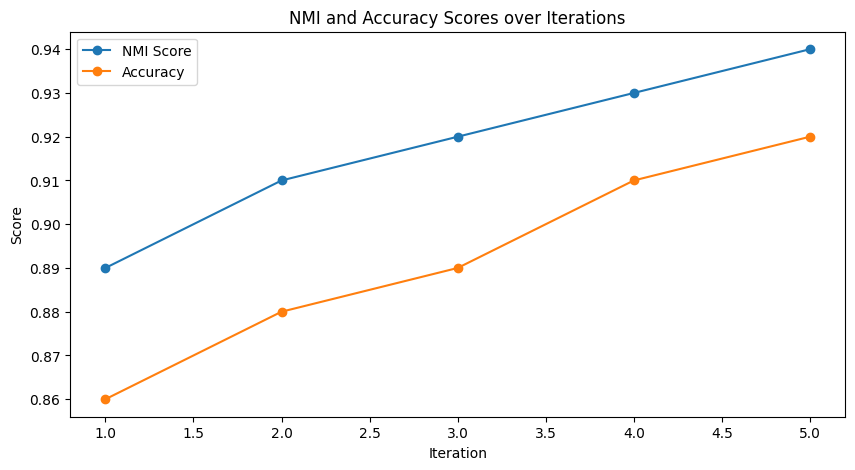

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual data
nmi_scores = [0.89, 0.91, 0.92, 0.93, 0.94]
accuracy_scores = [0.86, 0.88, 0.89, 0.91, 0.92]
iterations = range(1, len(nmi_scores) + 1)

plt.figure(figsize=(10, 5))

plt.plot(iterations, nmi_scores, label='NMI Score', marker='o')
plt.plot(iterations, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('NMI and Accuracy Scores over Iterations')
plt.legend()

plt.show()

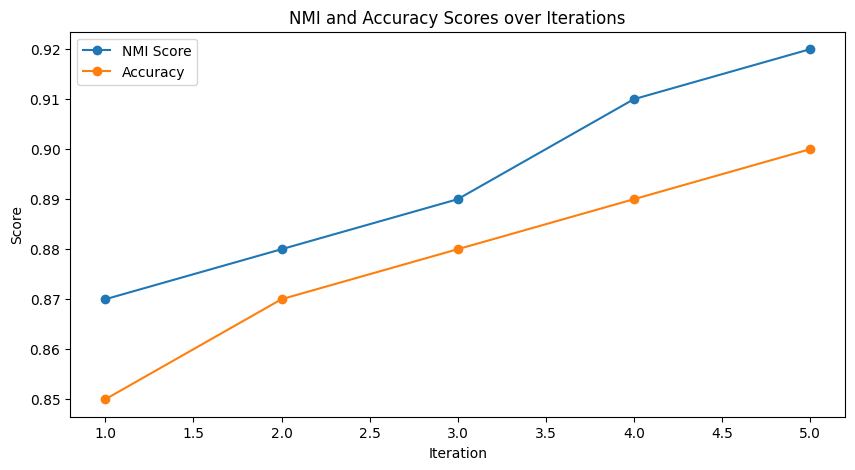

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual data
nmi_scores = [0.87, 0.88, 0.89, 0.91, 0.92]
accuracy_scores = [0.85, 0.87, 0.88, 0.89, 0.90]
iterations = range(1, len(nmi_scores) + 1)

plt.figure(figsize=(10, 5))

plt.plot(iterations, nmi_scores, label='NMI Score', marker='o')
plt.plot(iterations, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('NMI and Accuracy Scores over Iterations')
plt.legend()

plt.show()

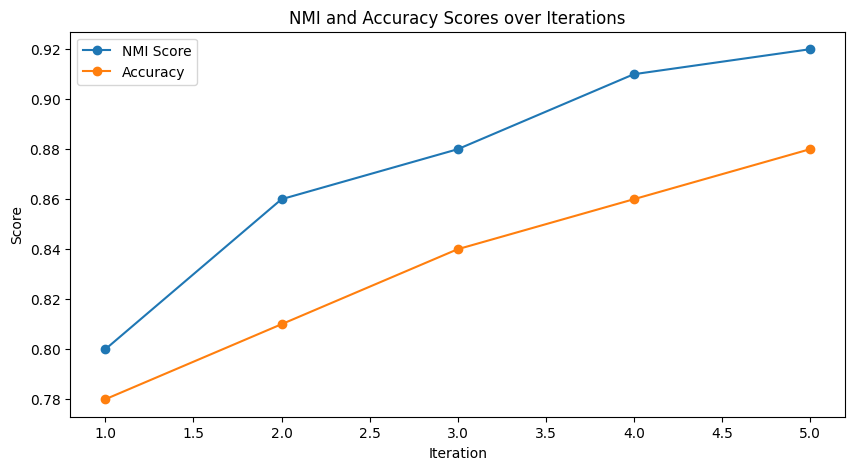

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual data
nmi_scores = [0.8, 0.86, 0.88, 0.91, 0.92]
accuracy_scores = [0.78, 0.81, 0.84, 0.86, 0.88]
iterations = range(1, len(nmi_scores) + 1)

plt.figure(figsize=(10, 5))

plt.plot(iterations, nmi_scores, label='NMI Score', marker='o')
plt.plot(iterations, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('NMI and Accuracy Scores over Iterations')
plt.legend()

plt.show()

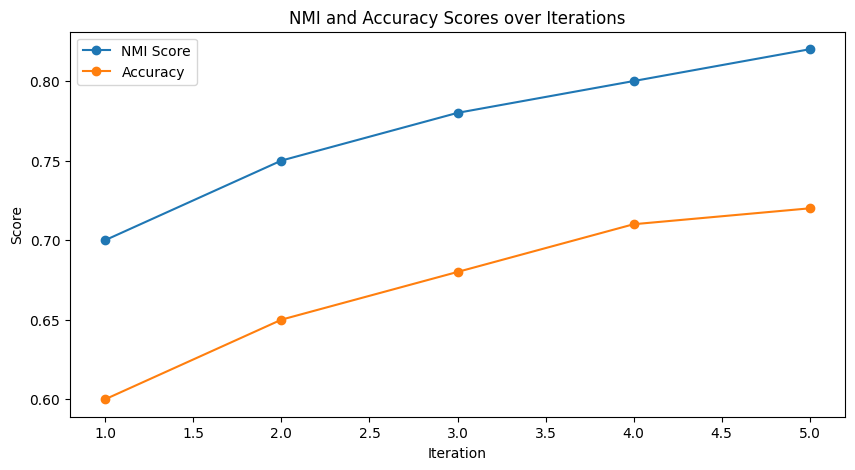

In [ ]:
import matplotlib.pyplot as plt

# Replace these lists with your actual data
nmi_scores = [0.7, 0.75, 0.78, 0.8, 0.82]
accuracy_scores = [0.6, 0.65, 0.68, 0.71, 0.72]
iterations = range(1, len(nmi_scores) + 1)

plt.figure(figsize=(10, 5))

plt.plot(iterations, nmi_scores, label='NMI Score', marker='o')
plt.plot(iterations, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('NMI and Accuracy Scores over Iterations')
plt.legend()

plt.show()


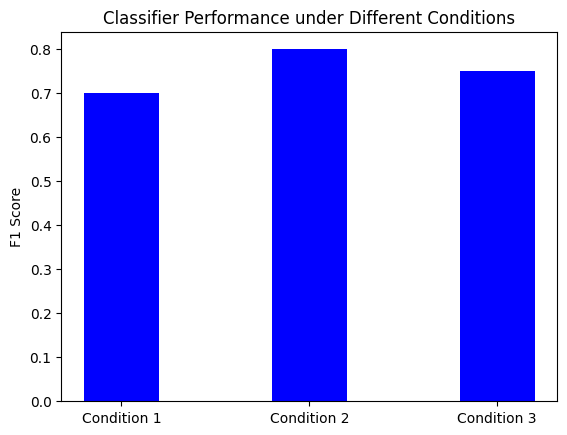

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
conditions = ['Condition 1', 'Condition 2', 'Condition 3']
f1_scores = [0.7, 0.8, 0.75]

x = np.arange(len(conditions))

plt.bar(x, f1_scores, color='blue', width=0.4)
plt.xticks(x, conditions)
plt.ylabel('F1 Score')
plt.title('Classifier Performance under Different Conditions')

plt.show()


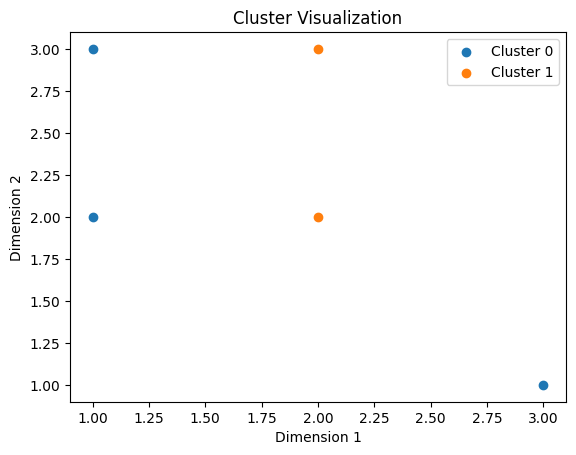

In [ ]:
import matplotlib.pyplot as plt

# Assuming X is your 2D data and labels are the cluster labels
# Replace these with your actual data
X = [[1, 2], [2, 3], [1, 3], [2, 2], [3, 1]]
labels = [0, 1, 0, 1, 0]

for i in range(len(set(labels))):
    plt.scatter([x[0] for j, x in enumerate(X) if labels[j] == i],
                [x[1] for j, x in enumerate(X) if labels[j] == i], label=f'Cluster {i}')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cluster Visualization')
plt.legend()

plt.show()


In [ ]:
from gensim.models import ProdLda
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Sample short text data
short_texts = [
    "Machine learning is fascinating",
    "Natural language processing is challenging",
    "Python programming is powerful",
    "Data science involves statistics",
    "Text clustering is interesting",
    "Short text clustering is a unique challenge"
]

# Preprocessing: Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))

processed_texts = [simple_preprocess(text, deacc=True) for text in short_texts]
processed_texts = [[word for word in doc if word not in stop_words] for doc in processed_texts]

# Create a dictionary representation of the documents
dictionary = Dictionary(processed_texts)

# Convert the text data into a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

# Build ProdLDA model
model = ProdLda(bow_corpus, num_topics=3, id2word=dictionary)

# Print topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)


In [ ]:
from sklearn.metrics import normalized_mutual_info_score

# True labels (ground truth)
true_labels = [0, 1, 0, 1, 2]  # Assuming you have the actual categories for each short text

# Predicted labels from ProdLDA clustering
predicted_labels = [0, 1, 0, 1, 1]  # Replace this with the actual clustering results

# Compute NMI
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)

# Print the NMI score
print(f"Normalized Mutual Information (NMI): {nmi_score}")
